In [1]:
# ALWAYS RUN THIS CELL
# from AntennaNetwork import AntennaCNN#imports for next cells 
import numpy as np
import h5py
import torch
from tqdm.auto import tqdm
import torch.nn as nn
from AntennaNetwork import AntennaCNN

# model = AntennaCNN()
# print(model.fc_1.bias.shape)
# weights of fully conneceted layer are stored in transposee for some reeason, but need to keeep this in mind

# for name, param in model.named_parameters():
#     print(name, param.size())


In [2]:
# RUN THIS CELL TO IMPORT MODEL PARAMS FROM MATLAB (not necessary if already run)

# Load matlab data as file
with h5py.File('antenna_test.mat','r') as f:
    model = AntennaCNN()
    
    # C is a matlab variable cell array storing the weights and biases of conv and forward layers
    weights_and_biases = f.get('C')
    
    # load batchnorm params from matlab file
    bn_params = f.get("BN_Params") 
    
    # keys that can be accessed (to check that the matlab variables are loaded correctly
    # print(f.keys())
    
    # This works for getting the data into python. Have to transpose the last two dimensions for some reason for 
    # them to match it seems
    """
    data = f.get('XTest')
    data = np.array(data) # For converting to a NumPy arrayo
    data = np.transpose(data, [0, 1, 3, 2])
    
    print(data[0,:,:,:])
    """
    
    
    # stores reference to i'th item in C, then use to get from file
    
    # params.append(torch.tensor(f[weights[i,0]]))
    
    # This loop sets up the convolutional layer parameters of the model, weights and biases
    i = 0
    for name, params in list(model.named_parameters()):
        if (i % 4) != 0 and (i % 4) != 1:
            i+=1
            continue
        if i//4 == 10:
            break
    
        # Set convolutional layer params
        if i % 4 == 0:
            layers_weights = torch.tensor(np.array(f[weights_and_biases[(i//4)*2,0]]))
            # try with and without transposing maybe???
            layers_weights = torch.transpose(layers_weights, 3, 2)
        else:
            layers_weights = torch.squeeze(torch.tensor(np.array(f[weights_and_biases[(i//4)*2+1,0]])))
    
        with torch.no_grad():
            layers_weights = layers_weights
            params.data = nn.parameter.Parameter(layers_weights)
        i+=1
    
    # torch.save(model.state_dict(), "./saved/AntennaCNN")
    # model.load_state_dict(torch.load("./saved/AntennaCNN"))
    
    # This loop sets up the fully connected layer parameters of the model, weights and biases
    i = 0
    for name, params in list(model.named_parameters()):
        if i < 40 or ((i % 4) != 0 and (i % 4) != 1):
            i+=1
            continue
        # print(name, i)
    
        # Set forward layer params
        if i % 4 == 0:
            # transpose because torch Linear stores weights this way 
            layers_weights = torch.tensor(np.array(f[weights_and_biases[(i//4)*2,0]])).T
            # print(layers_weights.shape)
        else:
            # biases
            layers_weights = torch.squeeze(torch.tensor(np.array(f[weights_and_biases[(i//4)*2+1,0]])))
    
        with torch.no_grad():
            # print(layers_weights.shape)
            layers_weights = layers_weights
            params.data = nn.parameter.Parameter(layers_weights)
    
        i+=1
    
    # torch.save(model.state_dict(), "./saved/AntennaCNN")
    
    # This loop sets up the batch normalization layer parameters
    i = 0
    for name, m in model.named_children():
        if 'batchnorm' not in name:
            continue
        # mean = self.running_mean
        # variance = self.running_var
        # gamma = self.weight
        # beta = self.bias
        # batchnorm_params[i] will be four separate arrays, in the order:
        # running_mean, running_var, weight/gamme, beta/bias
        running_mean = torch.tensor(np.array(f[f[bn_params[i,0]][0,0]])).squeeze()#.double()
        running_var = torch.tensor(np.array(f[f[bn_params[i,0]][0,1]])).squeeze()#.double()
        weight = torch.tensor(np.array(f[f[bn_params[i,0]][0,2]])).squeeze()#.double()
        bias = torch.tensor(np.array(f[f[bn_params[i,0]][0,3]])).squeeze()#.double()
    
        # # Set convolutional layer params
        # layers_weights = torch.tensor(np.array(f[batchnorm_params[i]]))
    
        with torch.no_grad():
            m.running_mean = nn.parameter.Parameter(running_mean, requires_grad=False)
            m.running_var = nn.parameter.Parameter(running_var, requires_grad=False)
            m.weight = nn.parameter.Parameter(weight)
            m.bias = nn.parameter.Parameter(bias)
    
        i+=1
    
    torch.save(model.state_dict(), "./saved/AntennaCNN")

/home/sbfisher/.conda/envs/CadenceEnv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


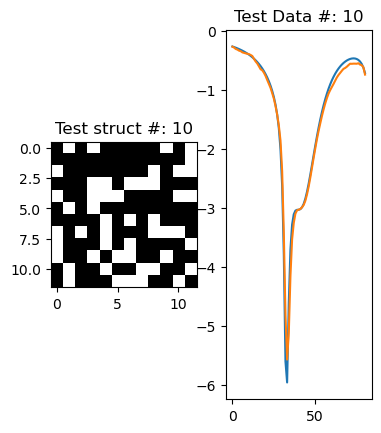

tensor(1., dtype=torch.float64)


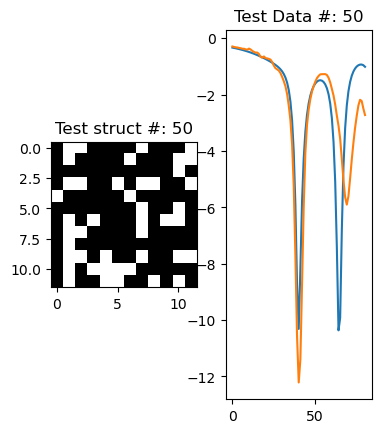

tensor(1., dtype=torch.float64)


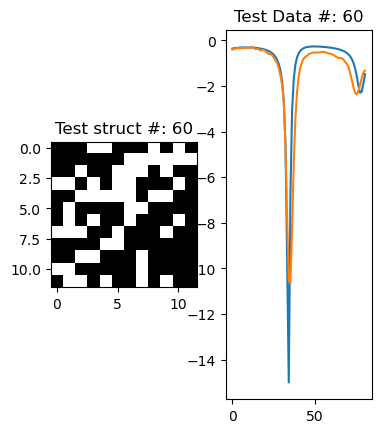

tensor(1., dtype=torch.float64)


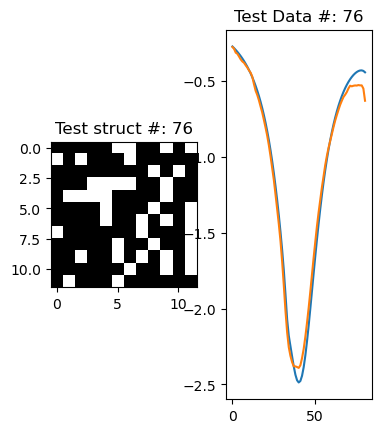

tensor(1., dtype=torch.float64)


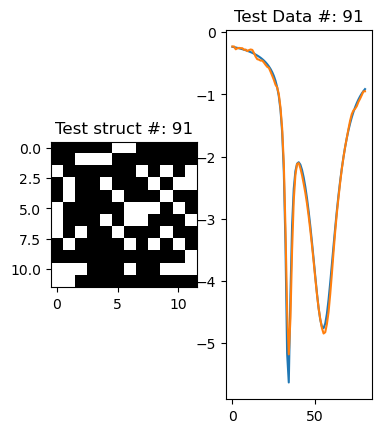

tensor(1., dtype=torch.float64)


In [3]:
## RUN THIS CELL TO LOAD MODEL IN FROM STATE DICT, RUN TESTS
import matplotlib.pyplot as plt

# model.load_state_dict(torch.load("./saved/AntennaCNN"))
# params = model.state_dict()

# testing to make sure these match matlab weights
# convweights[outut_chan, input_chan, x, y] should match matlabs [x, y, input_chan, output_chan]
# output_chan = 37
# input_chan = 57
# print(params["conv_5.weight"].size())
# print(params["conv_5.weight"][output_chan, input_chan, :, :])
# Seems to be working correctly!!

# after inspecting, this looks good. Seems to load the correct model from matlab
model.load_state_dict(torch.load("./saved/AntennaCNN"))
model.eval()
# print(model.fc_1.weight.shape) # should be 2000 x 13824 sinc estored in transpose

with h5py.File('antenna_test.mat','r') as f:
        
    x_test = torch.transpose(torch.tensor(np.array(f["XTest"])), 2, 3)
    y_test = torch.tensor(np.array(f["YTest"])).T
    # print(x_test.shape)
    # print(y_test.shape)
    
    def plot_example(number, x, y):
    
        # image seems transposed coming in from matlab
        test_struct = x[number,0,:,:]
        test_res = y[number,:]
    
        # now also get model predictions for this structure
        with torch.no_grad():
            to_pass = test_struct.unsqueeze(0).unsqueeze(0).float()
            # normalize the input
            to_pass = to_pass
            model_res = model(to_pass)
        
            plt.subplot(1,3,1)
            plt.imshow(1 - test_struct, cmap="gray")
            plt.title("Test struct #: {}".format(number+1))
            plt.subplot(1,3,2)
            x_ax = [i for i in range(len(test_res))]
            plt.plot(x_ax, test_res, label="true spectrum")
            plt.plot(x_ax, model_res.squeeze(), label = "pred spectrum")
            plt.title("Test Data #: {}".format(number+1))
            plt.show()

            print(test_struct[0][0])
    
    plot_example(9, x_test, y_test)
    plot_example(49, x_test, y_test)
    plot_example(59, x_test, y_test)
    plot_example(75, x_test, y_test)
    plot_example(90, x_test, y_test)
    # print(x_test[9,:,0,0])
    


In [7]:
# from pathlib import Path
# import os

# # Loading in 300nm (or is it micron) data
# DATA_PATH = os.path.join(Path(os.getcwd()).parent, "Test_Results300")

# files = os.listdir(DATA_PATH)
# for i in range(0, len(files)-1, 2):
#     data = os.path.join(DATA_PATH, files[i])
#     struct = os.path.join(DATA_PATH, files[i+1])

#     if os.path.isfile(f) and os.path.isfile(f2):
        
        

In [10]:
DATA_PATH = "./data/"

# save train and test datasets as csvs
with h5py.File('antenna_test.mat','r') as f:

    # TRANSPOSE X DATA BECAUSE IMAGES ARE FLIPPED FROM MATLAB (STORED IN COLUMN MAJOR)
    x_train = np.array(f["XTrain"]).transpose([0, 1, 3, 2])
    np.save(DATA_PATH + "x_train.npy", x_train)
    y_train = np.array(f["YTrain"]).T
    np.save(DATA_PATH + "y_train.npy", y_train)
    print(y_train.shape)
    x_test = np.array(f["XTest"]).transpose([0, 1, 3, 2])
    np.save(DATA_PATH + "x_test.npy", x_test)
    y_test = np.array(f["YTest"]).T
    np.save(DATA_PATH + "y_test.npy", y_test)
    print(x_test.shape)

    x_val = np.array(f["XValidation"]).transpose([0, 1, 3, 2])
    np.save(DATA_PATH + "x_val.npy", x_val)
    y_val = np.array(f["YValidation"]).T
    np.save(DATA_PATH + "y_val.npy", y_val)
    print(x_val.shape)

    

(70000, 81)
(3941, 1, 12, 12)
(5001, 1, 12, 12)
